In [1]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import graphviz
import pydotplus
from sklearn.externals.six import StringIO
import os
from queue import Queue

from IPython.display import Image

%matplotlib inline

In [2]:
def load_data() :
    '''
    读取训练数据和测试数据,并对label进行转换.
    '''
    data_train = np.loadtxt('data/svm-train.txt')
    data_test = np.loadtxt('data/svm-test.txt')
    x_train , y_train = data_train[ : , 0 : 2] , data_train[ : , 2].reshape(-1 , 1)
    x_test , y_test = data_test[ : , 0 : 2] , data_test[ : , 2].reshape(-1 , 1)
    y_train_label = np.array(list(map(lambda x : 1 if x > 0 else 0 , y_train))).reshape(-1 , 1)
    y_test_label = np.array(list(map(lambda x : 1 if x > 0 else 0 , y_test))).reshape(-1 , 1)
    return x_train , y_train , x_test , y_test , y_train_label , y_test_label

In [3]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self , split_loss_function , leaf_value_estimator ,
                 depth = 0 , min_sample = 5 , max_depth = 10) :
        '''
        决策树初始化,每个Decision_Tree object都代表一棵子树.
        Parameters:
            split_loss_function - 分裂损失函数 , 函数.
            leaf_value_estimator - 节点值计算函数 , 函数.
            depth - 节点深度 , 整数.
            min_sample - 节点允许的最少样本数 , 整数.
            max_depth - 决策树允许的最大深度 , 整数
            n_node - 该节点为子树的节点总数 , 整数
            is_leaf - 该节点是否为叶子结点 , True / False
            split_id - 该结点采取的分裂特征的标号 , 整数 / None
            split_value - 对应分裂特征的分裂阈值 , 整数 / None
            value - 节点值 , (分类树) label 整数 或者 (回归树) r 实数.
            left - 左子树 , Decision_Tree
            right - 右子树 , Decision_Tree
            loss_before_split - 分裂前的loss , 实数
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.n_node = 0
        self.is_leaf = None
        self.split_id = None
        self.split_value = None
        self.value = None
        self.left = None
        self.right = None
        self.loss_before_split = None

    def fit(self, X, y=None):
        '''
        根据训练样本实现递归建立决策树,其中使用了预剪枝.枚举所有的特征以及每个特征的取值,根据分裂损失函数计算最优分裂特征以及分裂点.
        Args:
            X - 训练样本输入特征 , 二维numpy数组(num_instances , num_features)
            y - 训练样本label , 二维numpy数组(num_instances , 1)
                                这里y也使用二维数组的好处是方便合并排序
        '''
        
        self.n_node = 1
        #达到树的最大深度
        if (self.depth == self.max_depth) :
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self
        
        #样本个数少于给定阈值
        if (len(y) <= self.min_sample) :
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self
        
        self.loss_before_split = self.split_loss_function(y)
        best_split_value = None
        best_split_id = None
        best_loss = self.loss_before_split
        best_left_X = None
        best_left_y = None
        best_right_X = None
        best_right_y = None
        
        X = np.concatenate([X , y] , axis = 1)
        
        for i in range(X.shape[1] - 1) :
            X = np.array(sorted(X , key = lambda x : x[i]))
            for j in range(X.shape[0] - 1) :
                left_X = X[ : j + 1 , : -1]
                left_y = X[ : j + 1 , -1].reshape(-1 , 1)
                right_X = X[j + 1 : , : -1]
                right_y = X[j + 1 : , -1].reshape(-1 , 1)
                left_loss = len(left_y) * self.split_loss_function(left_y) / len(y)
                right_loss = len(right_y) * self.split_loss_function(right_y) / len(y)
                if ((left_loss + right_loss) < best_loss) :
                    best_loss = left_loss + right_loss
                    best_split_value = left_X[j , i]
                    best_split_id = i
                    best_left_X = left_X
                    best_left_y = left_y
                    best_right_X = right_X
                    best_right_y = right_y
        
        if (best_split_id == None) :
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
        else :
            self.split_id = best_split_id
            self.split_value = best_split_value
            self.loss = best_loss
            self.left = Decision_Tree(self.split_loss_function , self.leaf_value_estimator , self.depth + 1 ,
                                     self.min_sample , self.max_depth)
            self.right = Decision_Tree(self.split_loss_function , self.leaf_value_estimator , self.depth + 1 ,
                                     self.min_sample , self.max_depth)
            self.left.fit(best_left_X , best_left_y)
            self.n_node += self.left.n_node
            self.right.fit(best_right_X , best_right_y)
            self.n_node += self.right.n_node
            
        return self

    def predict_instance(self, instance):
        '''
        对新样本的值进行预测.根据每一个节点的分裂特征标号split_id和分裂值split_value进行查找,直到叶子节点.
        Args:
            instance - 待预测样本特征 , 一维numpy数组(num_features)
        Returns :
            value - 预测值 , 整数 / 实数(根据决策树类型)
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)
        
def compute_entropy(label_array):
    '''
    根据给定label数组计算决策树节点的熵.
    Args:
        label_array - 节点样本的label数组 , 二维numpy数组(num_instances , 1)
    Returns:
        entropy - 熵值
    '''
    label_cnt = Counter(label_array.reshape(len(label_array)))
    entropy = 0.0
    for k , v in label_cnt.items() :
        prob = v * 1.0 / (len(label_array) * 1.0)
        entropy -= prob * np.log(1e-8 + prob)
    return entropy

def compute_gini(label_array):
    '''
    根据给定label数组计算决策树节点的基尼值.
    Args:
        label_array - 节点样本的label数组 , 二维numpy数组(num_instances , 1)
    Returns:
        gini - gini值
    '''
    label_cnt = Counter(label_array.reshape(len(label_array)))
    gini = 1.0
    for k , v in label_cnt.items() :
        prob = v * 1.0 / (len(label_array) * 1.0)
        gini -= prob * prob
    return gini

def most_common_label(label_array):
    '''
    对于分类树,返回该节点样本最多的类的标号.
    Args:
        label_array - 节点样本的label数组 , 二维numpy数组(num_instances , 1)
    Returns:
        label - 样本最多的类的标号
    '''
    label_cnt = Counter(label_array.reshape(len(label_array)))
    label = label_cnt.most_common(1)[0][0]
    return label

class Classification_Tree(BaseEstimator , ClassifierMixin):
    ''' 
    分类树类. loss_function_dict为可选的损失函数字典,实现了entropy(熵)和gini(基尼值)两种.
    '''
    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self , loss_function = 'entropy' , min_sample = 5 , max_depth = 10) :
        '''
        分类树object初始化.
        parameters:
            loss_function - 损失函数类型 , 函数
            min_sample - 节点的最小样本数 , 整数
            max_depth - 分类树的最大深度 , 整数
            tree - 分类树的根节点 , Decision_Tree类
            trees - 剪枝策略生成的各子树 , list
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function] ,
                                most_common_label ,
                                0 , min_sample , max_depth)
        self.trees = []

    def fit(self , X , y = None):
        '''
        分类树拟合函数.从根节点开始训练拟合.
        '''
        self.tree.fit(X,y)
        return self
    
    def tune(self) :
        '''
        决策树剪枝函数,采取的是自底向上依次剪枝.剪枝规则,寻找T_{k+1} , s.t. minimize(l(T_{k+1}) - l(T_k)).
        根据定理,子树是严格嵌套的,因此可以根据非叶子节点的个数进行枚举,每次用BFS遍历决策树,计算剪枝后的loss差值,
        取最小的作为答案加入队列.
        '''
        self.trees.append(self.tree)
        for step in range(self.tree.n_node) :
            temp_tree = copy.deepcopy(self.trees[-1])
            best_loss = None
            best_node = None
            tree_queue = Queue(maxsize = 0)
            tree_queue.push(temp_tree.tree)
            
            while (tree_queue.empty() != False) :
                now_node = tree_queue.get()
                if (now_node.is_leaf == True) :
                    continue
                if (best_loss == None or now_node.loss_before_split < best_loss) :
                    best_loss = now_node.loss_before_split
                    best_node = now_node
                if (now_node.left != None) :
                    tree_queue.put(now_node.left)
                if (now_node.right != None) :
                    tree_queue.put(now_node.right)
                
            best_node.is_leaf = True
            self.trees.append(temp_tree)            
        
        return self

    def predict_instance(self, instance):
        '''
        对新样本的值进行预测.从分类树根节点出发,根据每一个节点的分裂特征标号split_id和分裂值split_value进行查找,直到叶子节点.
        Args:
            instance - 待预测样本特征 , 一维numpy数组(num_features)
        Returns :
            value - 预测类别 , 整数
        '''
        value = self.tree.predict_instance(instance)
        return value

In [4]:
# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    med = np.median(y)
    mae = np.mean(np.abs(y - med))
    return mae

In [5]:
class Regression_Tree():
    '''
    回归树类. loss_function_dict为可选的损失函数字典,实现了MSE(均方根误差)和MAE(均绝对值误差)两种.
             estimator_dict为可选的节点值评估字典,实现了mean(平均值)和median(中位数)两种.
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        分类树object初始化.
        parameters:
            loss_function - 损失函数类型 , 函数
            min_sample - 节点的最小样本数 , 整数
            max_depth - 分类树的最大深度 , 整数
            tree - 分类树的根节点 , Decision_Tree类
            trees - 剪枝策略生成的各子树 , list
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)
        self.trees = []

    def fit(self , X , y = None) :
        '''
        分类树拟合函数.从根节点开始训练拟合.
        '''
        self.tree.fit(X , y)
        return self
    
    def tune(self) :
        '''
        决策树剪枝函数,采取的是自底向上依次剪枝.剪枝规则,寻找T_{k+1} , s.t. minimize(l(T_{k+1}) - l(T_k)).
        根据定理,子树是严格嵌套的,因此可以根据非叶子节点的个数进行枚举,每次用BFS遍历决策树,计算剪枝后的loss差值,
        取最小的作为答案加入队列.
        '''
        self.trees.append(self.tree)
        for step in range(self.tree.n_node) :
            temp_tree = copy.deepcopy(self.trees[-1])
            best_loss = None
            best_node = None
            tree_queue = Queue(maxsize = 0)
            tree_queue.push(temp_tree.tree)
            
            while (tree_queue.empty() != False) :
                now_node = tree_queue.get()
                if (now_node.is_leaf == True) :
                    continue
                if (best_loss == None or now_node.loss_before_split < best_loss) :
                    best_loss = now_node.loss_before_split
                    best_node = now_node
                if (now_node.left != None) :
                    tree_queue.put(now_node.left)
                if (now_node.right != None) :
                    tree_queue.put(now_node.right)
                
            best_node.is_leaf = True
            self.trees.append(temp_tree)            
        
        return self

    def predict_instance(self , instance):
        '''
        对新样本的值进行预测.从分类树根节点出发,根据每一个节点的分裂特征标号split_id和分裂值split_value进行查找,直到叶子节点.
        Args:
            instance - 待预测样本特征 , 一维numpy数组(num_features)
        Returns :
            value - 预测值 , 实数
        '''
        value = self.tree.predict_instance(instance)
        return value

In [6]:
def Experiment1(x_train , y_train , x_test , y_test , y_train_label , y_test_label) :
    '''
    实验一,实现分类树模型,构建不同深度的分类树对二分类数据进行拟合.绘制图表,观察实验现象,当样本较少,深度较大时,容易出现过拟合现象.
    '''
    clf1 = Classification_Tree(max_depth = 1)
    clf1.fit(x_train, y_train_label)

    clf2 = Classification_Tree(max_depth = 2)
    clf2.fit(x_train, y_train_label)

    clf3 = Classification_Tree(max_depth = 3)
    clf3.fit(x_train, y_train_label)

    clf4 = Classification_Tree(max_depth = 4)
    clf4.fit(x_train, y_train_label)

    clf5 = Classification_Tree(max_depth = 5)
    clf5.fit(x_train, y_train_label)
    
    clf6 = Classification_Tree(max_depth = 6)
    clf6.fit(x_train, y_train_label)

    x_min, x_max = x_train[ : , 0].min() - 1 , x_train[ : , 0].max() + 1
    y_min, y_max = x_train[ : , 1].min() - 1 , x_train[ : , 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min , x_max , 0.1) , np.arange(y_min , y_max , 0.1))

    f, axarr = plt.subplots(2 , 3 , sharex = 'col' , sharey = 'row' , figsize = (10, 8))

    for idx, clf, tt in zip(product([0 , 1] , [0 , 1 , 2]),
                        [clf1 , clf2 , clf3 , clf4 , clf5 , clf6],
                        ['Depth = {}'.format(n) for n in range(1 , 7)]):

        Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel() , yy.ravel()]])
        Z = Z.reshape(xx.shape)
    

        axarr[idx[0] , idx[1]].contourf(xx , yy , Z , alpha = 0.4)
        axarr[idx[0] , idx[1]].scatter(x_train[ : , 0] , x_train[ : , 1] , c=y_train_label.reshape(len(y_train_label)) 
                                       , alpha = 0.8)
    axarr[idx[0] , idx[1]].set_title(tt)

    plt.show()

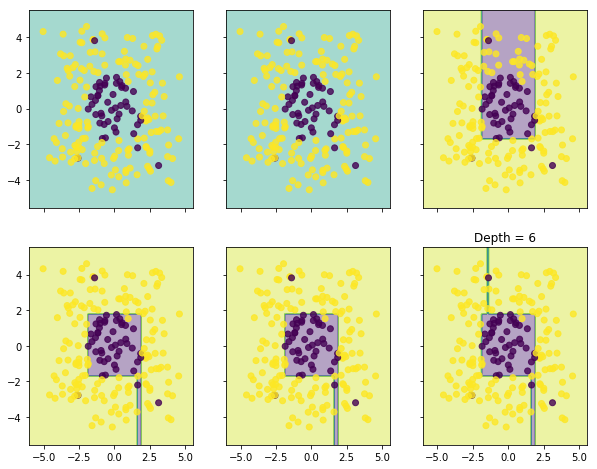

In [7]:
x_train , y_train , x_test , y_test , y_train_label , y_test_label = load_data()
Experiment1(x_train , y_train , x_test , y_test , y_train_label , y_test_label)

In [8]:
def Experiment2(x_train , y_train , x_test , y_test , y_train_label , y_test_label) :
    '''
    实验二,对sklearn包的二分类树,进行训练拟合,并利用Graphviz进行分类树的节点可视化工作.
    '''
    clf = DecisionTreeClassifier(criterion = 'entropy' , max_depth = 2 , min_samples_split = 5)
    clf.fit(x_train , y_train_label)
    export_graphviz(clf , out_file = 'tree_classifier.dot')
    !dot -Tpng tree_classifier.dot -o tree_classifier.png

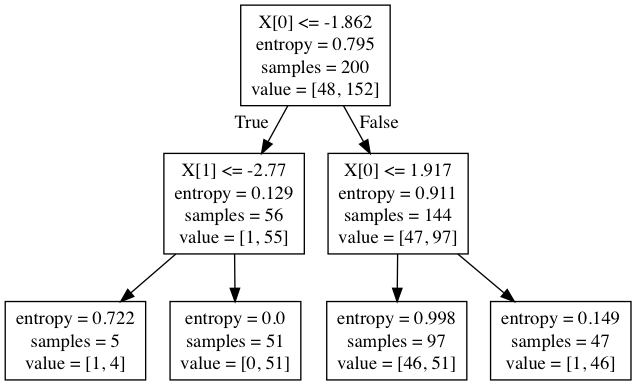

In [9]:
Experiment2(x_train , y_train , x_test , y_test , y_train_label , y_test_label)
Image(filename='tree_classifier.png')

In [10]:
def Experiment3() :
    '''
    实验三,利用回归树对一维数据进行回归分析和可视化.当树深度较小时,欠拟合现象严重,当深度很大时,容易出现局部的过拟合.
    另外,从图像中可以看出,决策树的区域是平行于x轴和y轴的,相比于SVM,光滑性很差.
    '''
    data_krr_train = np.loadtxt('data/krr-train.txt')
    data_krr_test = np.loadtxt('data/krr-test.txt')
    x_krr_train , y_krr_train = data_krr_train[ : , 0].reshape(-1 , 1) , data_krr_train[ : , 1].reshape(-1 , 1)
    x_krr_test , y_krr_test = data_krr_test[ : , 0].reshape(-1 , 1) , data_krr_test[ : , 1].reshape(-1 , 1)

    # Training regression trees with different depth
    clf1 = Regression_Tree(max_depth=1,  min_sample=1, loss_function='mae', estimator='median')
    clf1.fit(x_krr_train, y_krr_train)

    clf2 = Regression_Tree(max_depth=2,  min_sample=1, loss_function='mae', estimator='median')
    clf2.fit(x_krr_train, y_krr_train)

    clf3 = Regression_Tree(max_depth=3,  min_sample=1, loss_function='mae', estimator='median')
    clf3.fit(x_krr_train, y_krr_train)

    clf4 = Regression_Tree(max_depth=4,  min_sample=1, loss_function='mae', estimator='median')
    clf4.fit(x_krr_train, y_krr_train)

    clf5 = Regression_Tree(max_depth=5,  min_sample=1, loss_function='mae', estimator='median')
    clf5.fit(x_krr_train, y_krr_train)

    clf6 = Regression_Tree(max_depth=6,  min_sample=1, loss_function='mae', estimator='median')
    clf6.fit(x_krr_train, y_krr_train)

    plot_size = 0.001
    x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

    f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

    for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                            [clf1, clf2, clf3, clf4, clf5, clf6],
                            ['Depth = {}'.format(n) for n in range(1, 7)]):
    
        y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
        axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
        axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
        axarr2[idx[0], idx[1]].set_title(tt)
        axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

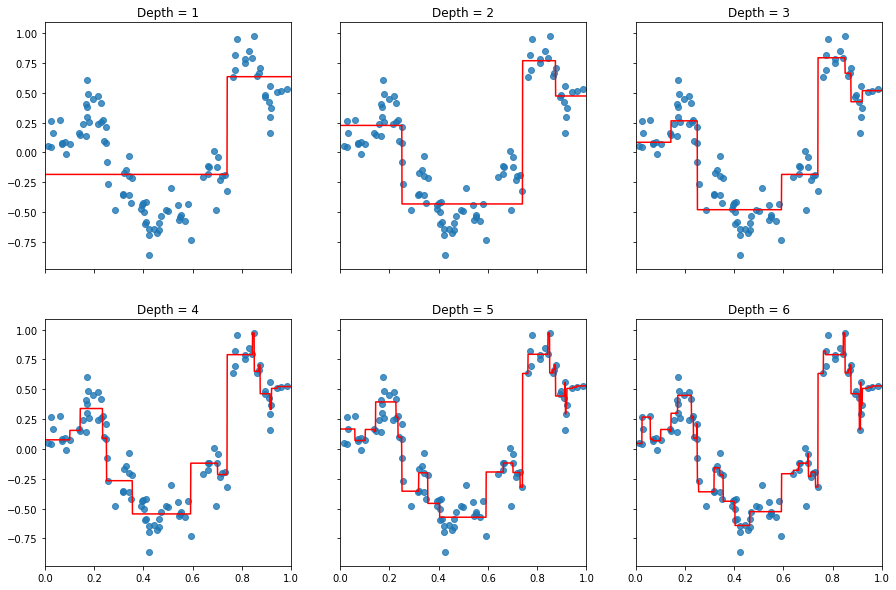

In [11]:
Experiment3()

In [12]:
def pseudo_residual_L2(y , y_):
    '''
    根据当前GBM的预测值计算负梯度(square损失的时候梯度等于残差).
    Args:
        y - 训练样本的真实值 , 二维numpy数组 (num_instances , 1)
        y_ - 当前模型的预测值 , 二维numpy数组 (num_instances , 1)
    Returns :
        pseudo residual - 负残差 , 二维numpy数组(num_instances , 1)
    '''
    return y - y_

In [13]:
class gradient_boosting():
    '''
    梯度提升类(基学习器选取的是回归树)
    '''
    def __init__(self, n_estimator , pseudo_residual_func , learning_rate=0.1 , min_sample=5 , max_depth=3):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual
        :param learning_rate: step size of gradient descent
        '''
        '''
        初始化梯度提升类.
        Parameters:
            n_estimator - 基学习器个数也是梯度提升轮数 , 整数.
            pseudo_residual_func - 负梯度计算函数 , 函数.
            learning_rate - 学习率 , 实数.
            min_sample - 决策树每个节点允许分裂的最少样本个数 , 整数.
            max_depth - 决策树最大深度 , 整数.
        '''
        
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth
        
        self.base_models = []
    
    def fit(self, X , y):
        '''
        梯度提升树拟合过程,每次计算负梯度,训练基学习器拟合负梯度,依次迭代下去.
        Args:
            X : 训练样本输入特征 , 二维numpy数组(num_instances , num_features)
            y : 训练样本值 , 二维numpy数组(num_instances , 1)
        '''

        y_ = np.zeros(len(y))
        for i in range(self.n_estimator) :
            y_ = np.zeros((len(y) , 1))
            for j in range(len(self.base_models)) :
                for k in range(len(y)) :
                    y_[k][0] += self.learning_rate * self.base_models[j].predict_instance(X[k])
            clf = Regression_Tree(min_sample = self.min_sample , max_depth = self.max_depth ,
                                  loss_function='mse', estimator='mean')
            clf.fit(X , self.pseudo_residual_func(y , y_).reshape(-1 , 1))
            self.base_models.append(clf)
    
    def predict(self, X):
        '''
        梯度提升树预测函数.将所有基决策树的结果加权汇总.
        Args:
            X : 待预测样本输入特征 , 二维numpy数组(num_instances , num_features)
        Returns :
            y_ : 预测样本值 , 一维numpy数组(num_instances)
        '''
        y_ = np.zeros(len(X))
        for i in range(self.n_estimator) :
            for j in range(len(X)) :
                y_[j] += self.learning_rate * self.base_models[i].predict_instance(X[j])
        return y_

In [14]:
def Experiment4(x_train , y_train , x_test , y_test , y_train_label , y_test_label) :
    '''
    实验四,GBDT可视化.
    '''
    x_min, x_max = x_train[ : , 0].min() - 1, x_train[ : , 0].max() + 1
    y_min, y_max = x_train[ : , 1].min() - 1, x_train[ : , 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min , x_max , 0.1),
                     np.arange(y_min , y_max , 0.1))

    f, axarr = plt.subplots(2 , 3 , sharex='col' , sharey='row' , figsize=(10 , 8))

    for idx, i, tt in zip(product([0 , 1] , [0 , 1 , 2]),
                       [1 , 5 , 10 , 20 , 50 , 100], 
                       ['n_estimator = {}'.format(n) for n in [1 , 5 , 10 , 20 , 50 , 100]]):
    
        gbt = gradient_boosting(n_estimator = i , pseudo_residual_func = pseudo_residual_L2 , max_depth = 2)  
        gbt.fit(x_train , y_train)
                   
        Z = np.sign(gbt.predict(np.c_[xx.ravel() , yy.ravel()]))
        Z = Z.reshape(xx.shape)

        axarr[idx[0], idx[1]].contourf(xx , yy , Z , alpha = 0.4)
        axarr[idx[0], idx[1]].scatter(x_train[ : , 0], x_train[ : , 1], c = y_train_label.reshape(len(y_train_label)) , alpha = 0.8)
        axarr[idx[0], idx[1]].set_title(tt)

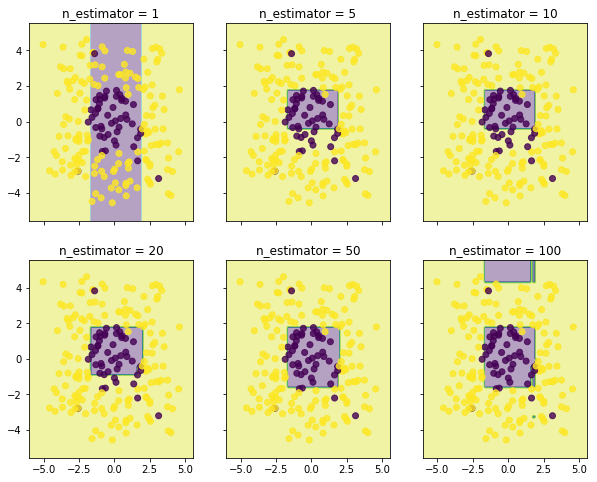

In [15]:
Experiment4(x_train , y_train , x_test , y_test , y_train_label , y_test_label)

In [16]:
def Experiment5() :
    '''
    实验五 , GBDT 一维回归问题的可视化实验.
    '''
    data_krr_train = np.loadtxt('data/krr-train.txt')
    data_krr_test = np.loadtxt('data/krr-test.txt')
    x_krr_train , y_krr_train = data_krr_train[ : , 0].reshape(-1 , 1) , data_krr_train[ : , 1].reshape(-1 , 1)
    x_krr_test , y_krr_test = data_krr_test[ : , 0].reshape(-1 , 1) , data_krr_test[ : , 1].reshape(-1 , 1)
    plot_size = 0.001
    x_range = np.arange(0. , 1. , plot_size).reshape(-1 , 1)

    f2, axarr2 = plt.subplots(2 , 3 , sharex = 'col' , sharey = 'row' , figsize = (15 , 10))

    for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
        gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, max_depth=2)  
        gbm_1d.fit(x_krr_train, y_krr_train)
    
        y_range_predict = gbm_1d.predict(x_range)

        axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
        axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
        axarr2[idx[0], idx[1]].set_title(tt)
        axarr2[idx[0], idx[1]].set_xlim(0, 1)
    

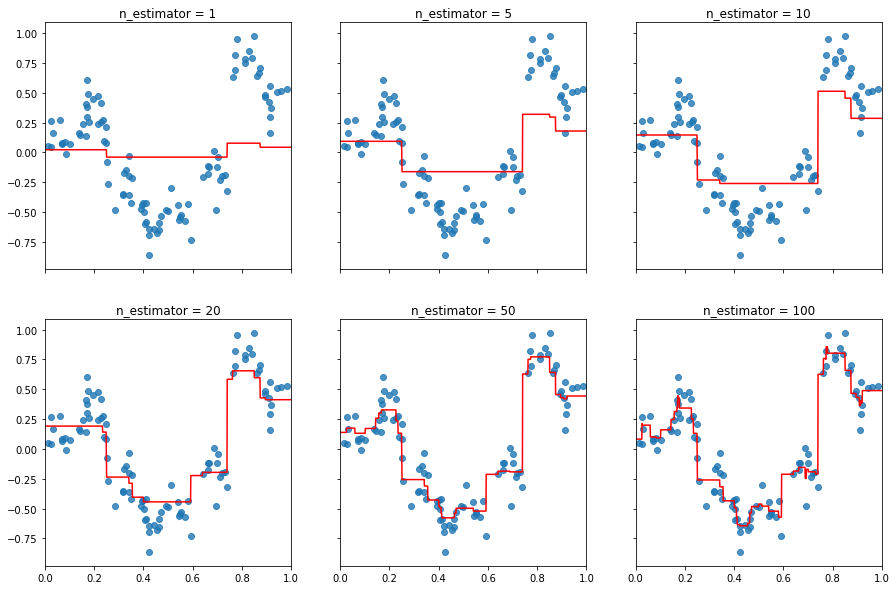

In [17]:
Experiment5()